<a href="https://colab.research.google.com/github/Abhiram-k1/Elevate-Labs-AI-ML-Internship/blob/main/Fraudulent_Transactions_using_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (150632, 31)
Missing values: 23
Class Distribution:
Class
0.0    150337
1.0       294
Name: count, dtype: int64


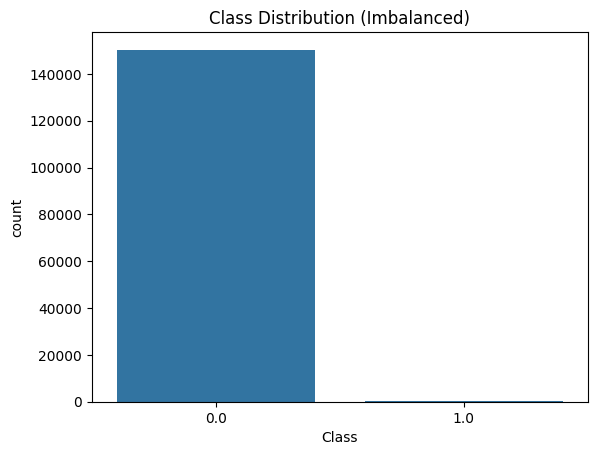

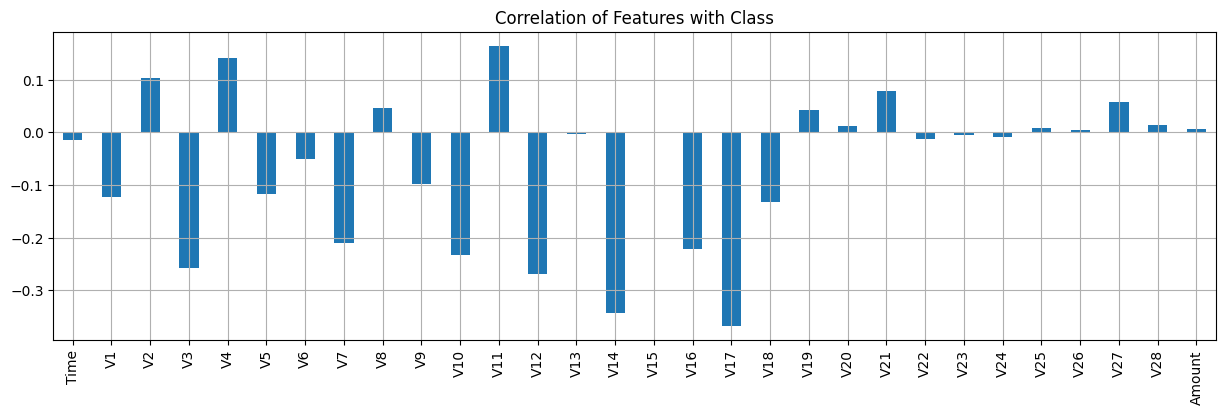

Shape after feature selection: (150631, 11)


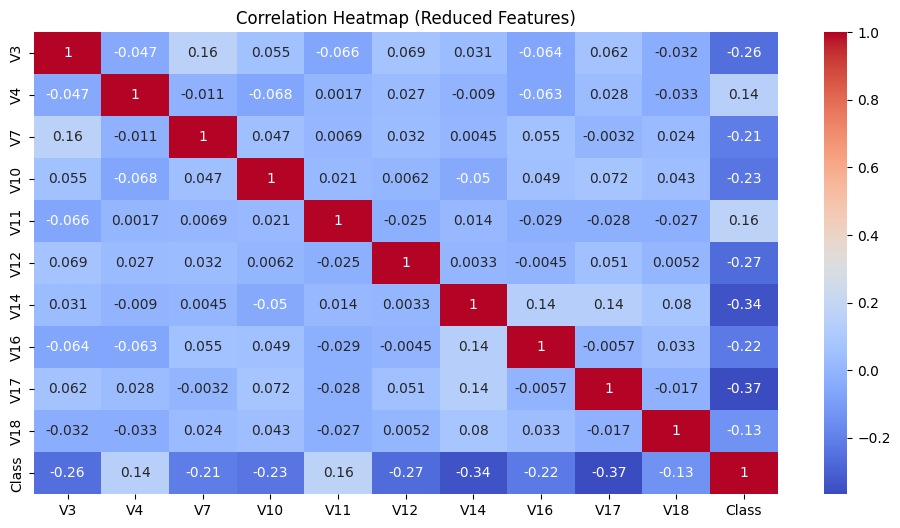

After Downsampling: (588, 10) (588,)


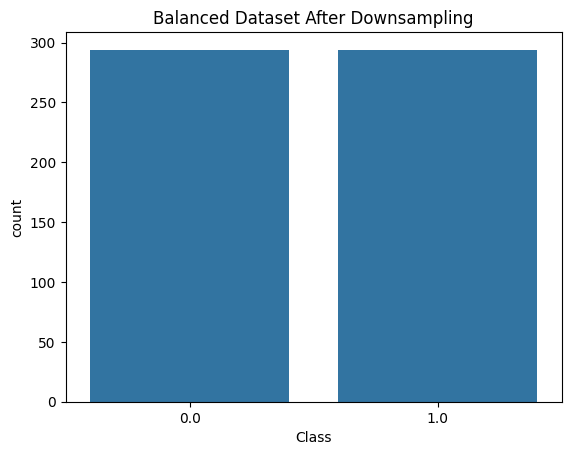

Train Shape: (470, 10)
Test Shape: (30127, 10)

Isolation Forest Results:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     30068
         1.0       0.16      0.81      0.27        59

    accuracy                           0.99     30127
   macro avg       0.58      0.90      0.63     30127
weighted avg       1.00      0.99      0.99     30127

ROC-AUC: 0.9025559015384338

Local Outlier Factor Results:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     30068
         1.0       0.00      0.00      0.00        59

    accuracy                           0.99     30127
   macro avg       0.50      0.49      0.50     30127
weighted avg       1.00      0.99      0.99     30127

ROC-AUC: 0.4949780497538912

XGBoost Classifier Results:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     30068
         1.0       0.04      0.86      0.08    

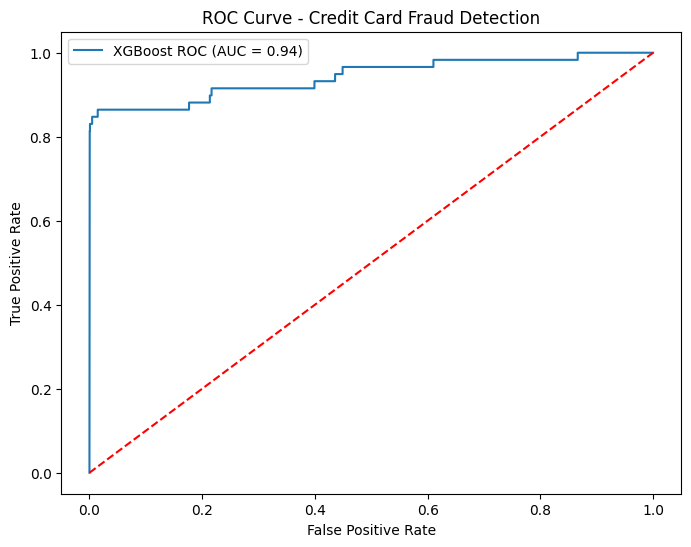

✅ Model saved as xgb_fraud_model.pkl


In [2]:
# ==============================
# Credit Card Fraud Detection
# ==============================

# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
import joblib

# ==============================
# 2. Load Dataset
# ==============================
df = pd.read_csv('creditcard.csv')

print(f"Shape: {df.shape}")
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Class Distribution:\n{df['Class'].value_counts()}")

# Handle NaNs safely (drop or fill)
df = df.dropna()      # option 1: drop rows with NaN
# df = df.fillna(0)   # option 2: fill with zeros (use if dropping loses too much data)

sns.countplot(x='Class', data=df)
plt.title("Class Distribution (Imbalanced)")
plt.show()

# ==============================
# 3. Feature Selection
# ==============================
corr = df.corr()['Class']
plt.figure(figsize=(15,4))
corr[:-1].plot.bar(title="Correlation of Features with Class", grid=True)
plt.show()

# Keep only features with |correlation| > 0.13
df2 = df.copy()
for col in df.columns:
    if abs(corr[col]) < 0.13:
        df2.drop(columns=[col], inplace=True)

print("Shape after feature selection:", df2.shape)

plt.figure(figsize=(12,6))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Reduced Features)")
plt.show()

# ==============================
# 4. Handle Class Imbalance
# ==============================
X = df2.drop('Class', axis=1)
y = df2['Class']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("After Downsampling:", X_resampled.shape, y_resampled.shape)
sns.countplot(x=y_resampled)
plt.title("Balanced Dataset After Downsampling")
plt.show()

# ==============================
# 5. Train-Test Split
# ==============================
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_data = X_train_orig.copy()
train_data['Class'] = y_train_orig

majority = train_data[train_data['Class']==0]
minority = train_data[train_data['Class']==1]

majority_down = resample(majority, replace=False, n_samples=len(minority), random_state=42)
downsampled = pd.concat([majority_down, minority])

X_train_down = downsampled.drop('Class', axis=1)
y_train_down = downsampled['Class']

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_down)
X_test_scaled = scaler.transform(X_test_orig)

print("Train Shape:", X_train_scaled.shape)
print("Test Shape:", X_test_scaled.shape)

# ==============================
# 6. Anomaly Detection
# ==============================
# Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
y_pred_if = iso_forest.fit_predict(X_test_scaled)
y_pred_if = [1 if x==-1 else 0 for x in y_pred_if]

print("\nIsolation Forest Results:")
print(classification_report(y_test_orig, y_pred_if))
print("ROC-AUC:", roc_auc_score(y_test_orig, y_pred_if))

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred_lof = lof.fit_predict(X_test_scaled)
y_pred_lof = [1 if x==-1 else 0 for x in y_pred_lof]

print("\nLocal Outlier Factor Results:")
print(classification_report(y_test_orig, y_pred_lof))
print("ROC-AUC:", roc_auc_score(y_test_orig, y_pred_lof))

# ==============================
# 7. XGBoost Classifier
# ==============================
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train_down)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("\nXGBoost Classifier Results:")
print(classification_report(y_test_orig, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_orig, y_pred_xgb))

# ==============================
# 8. ROC Curve
# ==============================
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test_orig, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Credit Card Fraud Detection")
plt.legend()
plt.show()

# ==============================
# 9. Save Model
# ==============================
joblib.dump(xgb_model, "xgb_fraud_model.pkl")
print("✅ Model saved as xgb_fraud_model.pkl")
